Total patients with albumin: 81
Total patients with hemoglobin: 100
Patients with BOTH biomarkers: 81
ALBUMIN-HEMOGLOBIN CORRELATION ANALYSIS (ALL PATIENTS - over all timepoints available)
Total unique patients: 0
Total repeated patients: 81
Total patients: 81
Total measurements: 2879
OVERALL CORRELATION (ALL PATIENTS, ALL MEASUREMENTS)
Correlation: r=0.057
P-value: p=2.17e-03
Sample size: n=2879
Significance: Yes - Significant
TEMPORAL CORRELATION (REPEATED PATIENTS, ALL MEASUREMENTS POOLED)
Correlation: r=0.057
P-value: p=2.17e-03
Sample size: n=2879
Significance: Yes - Significant
WITHIN-PATIENT CORRELATIONS (INDIVIDUAL TEMPORAL PATTERNS)
Number of patients analyzed: 50
Mean within-patient correlation: r=0.239
Median within-patient correlation: r=0.217
Std deviation: 0.384

Patients with significant correlation (p<0.05): 21/50
Positive correlations: 36 (72.0%)
Negative correlations: 14 (28.0%)


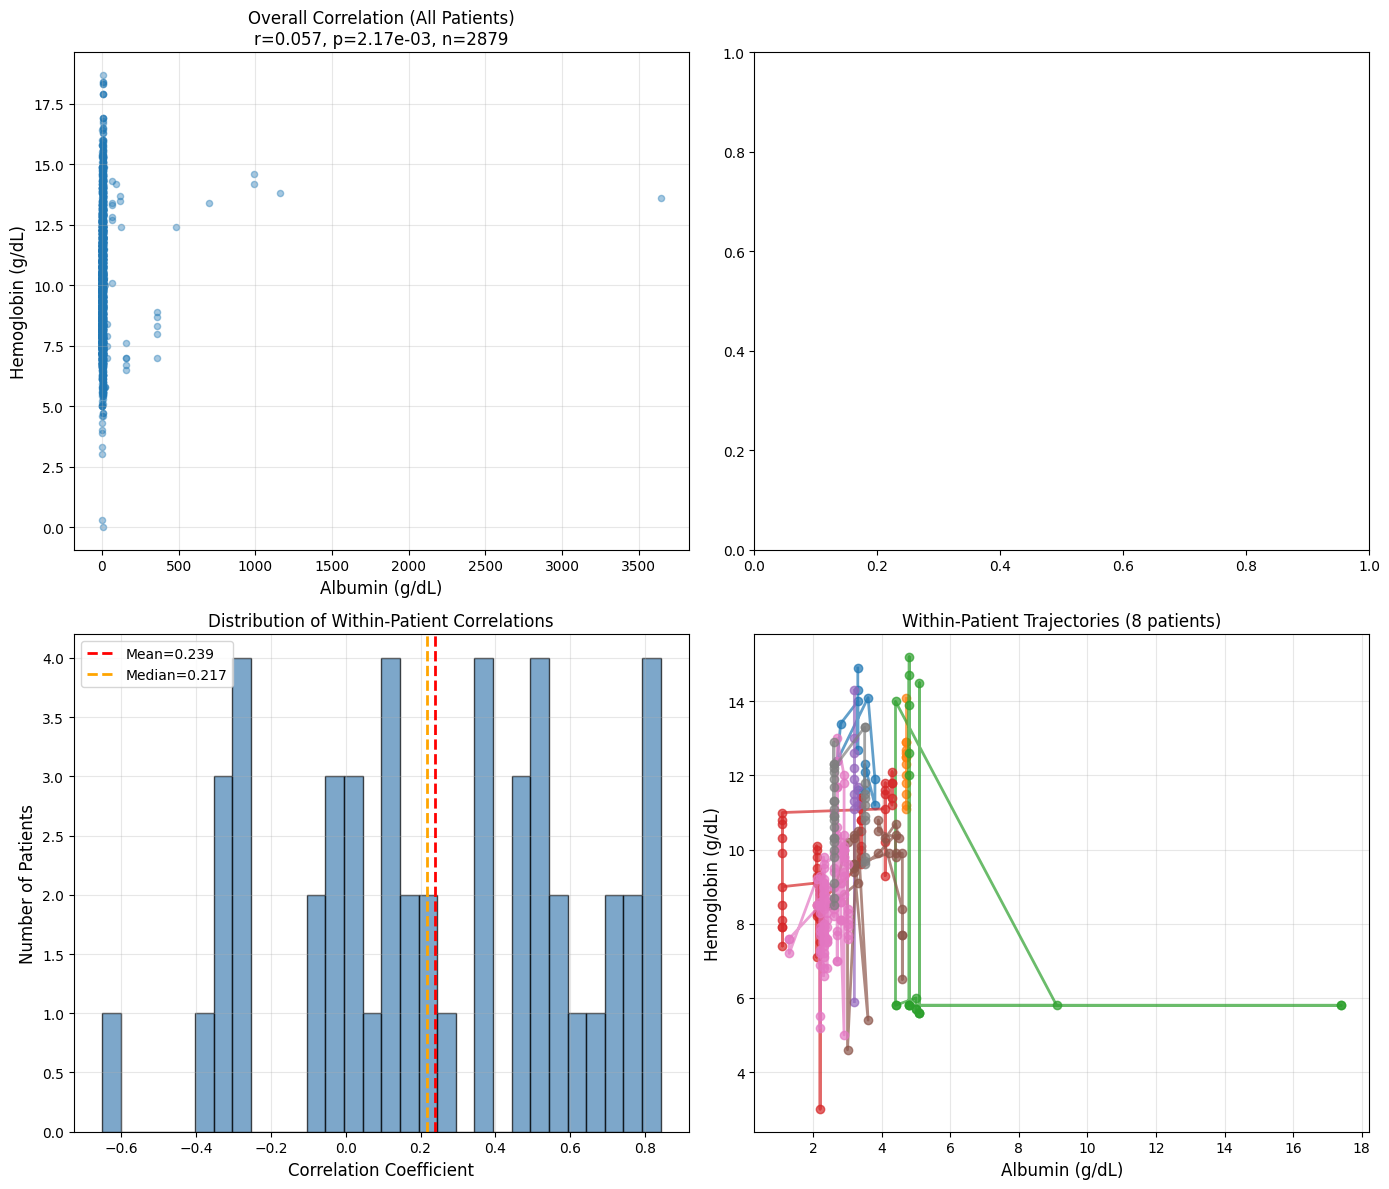

SUMMARY
Dataset validated with 81 patients
Overall correlation: r=0.057 (p=2.17e-03)
Mean within-patient correlation: r=0.239
Median within-patient correlation: r=0.217

Files saved:
  - albumin_hemoglobin_all_patients_over_all_points.csv
  - patient_correlation_details_over_all_points.csv


In [3]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

d_labitems = pd.read_csv('d_labitems.csv')
labevents = pd.read_csv('labevents.csv')

albumin_items = d_labitems[d_labitems['label'].str.contains('Albumin', case=False, na=False)]
hemoglobin_items = d_labitems[d_labitems['label'].str.contains('Hemoglobin', case=False, na=False)]

albumin_ids = albumin_items['itemid'].tolist()
hemoglobin_ids = hemoglobin_items['itemid'].tolist()

albumin_data = labevents[labevents['itemid'].isin(albumin_ids)].copy()
albumin_data = albumin_data[['subject_id', 'charttime', 'valuenum']].dropna()
albumin_data['charttime'] = pd.to_datetime(albumin_data['charttime'])
albumin_data = albumin_data.rename(columns={'valuenum': 'albumin'})

hemoglobin_data = labevents[labevents['itemid'].isin(hemoglobin_ids)].copy()
hemoglobin_data = hemoglobin_data[['subject_id', 'charttime', 'valuenum']].dropna()
hemoglobin_data['charttime'] = pd.to_datetime(hemoglobin_data['charttime'])
hemoglobin_data = hemoglobin_data.rename(columns={'valuenum': 'hemoglobin'})

patients_with_albumin = set(albumin_data['subject_id'].unique())
patients_with_hemoglobin = set(hemoglobin_data['subject_id'].unique())
patients_with_both = patients_with_albumin.intersection(patients_with_hemoglobin)

print(f"Total patients with albumin: {len(patients_with_albumin)}")
print(f"Total patients with hemoglobin: {len(patients_with_hemoglobin)}")
print(f"Patients with BOTH biomarkers: {len(patients_with_both)}")

albumin_data = albumin_data[albumin_data['subject_id'].isin(patients_with_both)]
hemoglobin_data = hemoglobin_data[hemoglobin_data['subject_id'].isin(patients_with_both)]

all_patients_data = []

for patient_id in patients_with_both:
    patient_albumin = albumin_data[albumin_data['subject_id'] == patient_id].copy()
    patient_hemoglobin = hemoglobin_data[hemoglobin_data['subject_id'] == patient_id].copy()

    all_times = pd.concat([patient_albumin['charttime'], patient_hemoglobin['charttime']]).unique()
    all_times = pd.Series(sorted(all_times))

    patient_df = pd.DataFrame({'charttime': all_times})
    patient_df['subject_id'] = patient_id

    patient_df = pd.merge_asof(
        patient_df.sort_values('charttime'),
        patient_albumin[['charttime', 'albumin']].sort_values('charttime'),
        on='charttime',
        direction='nearest'
    )

    patient_df = pd.merge_asof(
        patient_df.sort_values('charttime'),
        patient_hemoglobin[['charttime', 'hemoglobin']].sort_values('charttime'),
        on='charttime',
        direction='nearest'
    )

    all_patients_data.append(patient_df)

merged = pd.concat(all_patients_data, ignore_index=True)

merged['albumin'] = merged.groupby('subject_id')['albumin'].transform(
    lambda x: x.fillna(x.mean())
)
merged['hemoglobin'] = merged.groupby('subject_id')['hemoglobin'].transform(
    lambda x: x.fillna(x.mean())
)

all_patients_data = merged.dropna(subset=['albumin', 'hemoglobin'])

measurement_counts = all_patients_data.groupby('subject_id').size()
unique_patients = measurement_counts[measurement_counts == 1].index
repeated_patients = measurement_counts[measurement_counts >= 2].index

unique_data = all_patients_data[all_patients_data['subject_id'].isin(unique_patients)]
repeated_data = all_patients_data[all_patients_data['subject_id'].isin(repeated_patients)]

print(f"ALBUMIN-HEMOGLOBIN CORRELATION ANALYSIS (ALL PATIENTS - over all timepoints available)")
print(f"Total unique patients: {len(unique_patients)}")
print(f"Total repeated patients: {len(repeated_patients)}")
print(f"Total patients: {len(unique_patients) + len(repeated_patients)}")
print(f"Total measurements: {len(all_patients_data)}")

r_all, p_all = pearsonr(all_patients_data['albumin'], all_patients_data['hemoglobin'])
print(f"OVERALL CORRELATION (ALL PATIENTS, ALL MEASUREMENTS)")
print(f"Correlation: r={r_all:.3f}")
print(f"P-value: p={p_all:.2e}")
print(f"Sample size: n={len(all_patients_data)}")
print(f"Significance: {'Yes - Significant' if p_all < 0.05 else 'No - Not significant'}")

if len(unique_data) > 0:
    r_unique, p_unique = pearsonr(unique_data['albumin'], unique_data['hemoglobin'])
    print(f"CROSS-SECTIONAL CORRELATION (UNIQUE PATIENTS ONLY)")
    print(f"Correlation: r={r_unique:.3f}")
    print(f"P-value: p={p_unique:.2e}")
    print(f"Sample size: n={len(unique_data)}")
    print(f"Significance: {'Yes - Significant' if p_unique < 0.05 else 'No - Not significant'}")

r_repeated_overall, p_repeated_overall = pearsonr(repeated_data['albumin'], repeated_data['hemoglobin'])
print(f"TEMPORAL CORRELATION (REPEATED PATIENTS, ALL MEASUREMENTS POOLED)")
print(f"Correlation: r={r_repeated_overall:.3f}")
print(f"P-value: p={p_repeated_overall:.2e}")
print(f"Sample size: n={len(repeated_data)}")
print(f"Significance: {'Yes - Significant' if p_repeated_overall < 0.05 else 'No - Not significant'}")

within_patient_correlations = []
patient_correlation_details = []

for patient_id in repeated_patients:
    patient_data = repeated_data[repeated_data['subject_id'] == patient_id]

    if len(patient_data) >= 2:
        albumin_std = patient_data['albumin'].std()
        hemoglobin_std = patient_data['hemoglobin'].std()

        if albumin_std > 0 and hemoglobin_std > 0:
            try:
                r, p = pearsonr(patient_data['albumin'], patient_data['hemoglobin'])
                if not np.isnan(r):
                    within_patient_correlations.append(r)
                    patient_correlation_details.append({
                        'patient_id': patient_id,
                        'n_measurements': len(patient_data),
                        'correlation': r,
                        'p_value': p
                    })
            except:
                pass

if len(within_patient_correlations) > 0:
    mean_within_r = np.mean(within_patient_correlations)
    median_within_r = np.median(within_patient_correlations)
    std_within_r = np.std(within_patient_correlations)

    print(f"WITHIN-PATIENT CORRELATIONS (INDIVIDUAL TEMPORAL PATTERNS)")
    print(f"Number of patients analyzed: {len(within_patient_correlations)}")
    print(f"Mean within-patient correlation: r={mean_within_r:.3f}")
    print(f"Median within-patient correlation: r={median_within_r:.3f}")
    print(f"Std deviation: {std_within_r:.3f}")

    significant_patients = [p for p in patient_correlation_details if p['p_value'] < 0.05]
    print(f"\nPatients with significant correlation (p<0.05): {len(significant_patients)}/{len(patient_correlation_details)}")

    positive_corr = [r for r in within_patient_correlations if r > 0]
    negative_corr = [r for r in within_patient_correlations if r < 0]
    print(f"Positive correlations: {len(positive_corr)} ({len(positive_corr)/len(within_patient_correlations)*100:.1f}%)")
    print(f"Negative correlations: {len(negative_corr)} ({len(negative_corr)/len(within_patient_correlations)*100:.1f}%)")

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

axes[0, 0].scatter(all_patients_data['albumin'], all_patients_data['hemoglobin'], alpha=0.4, s=20)
axes[0, 0].set_xlabel('Albumin (g/dL)', fontsize=12)
axes[0, 0].set_ylabel('Hemoglobin (g/dL)', fontsize=12)
axes[0, 0].set_title(f'Overall Correlation (All Patients)\nr={r_all:.3f}, p={p_all:.2e}, n={len(all_patients_data)}', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

if len(unique_data) > 0:
    axes[0, 1].scatter(unique_data['albumin'], unique_data['hemoglobin'], alpha=0.5, s=30, color='green')
    axes[0, 1].set_xlabel('Albumin (g/dL)', fontsize=12)
    axes[0, 1].set_ylabel('Hemoglobin (g/dL)', fontsize=12)
    axes[0, 1].set_title(f'Cross-Sectional (Unique Patients)\nr={r_unique:.3f}, p={p_unique:.2e}, n={len(unique_data)}', fontsize=12)
    axes[0, 1].grid(True, alpha=0.3)

if len(within_patient_correlations) > 0:
    axes[1, 0].hist(within_patient_correlations, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[1, 0].axvline(mean_within_r, color='red', linestyle='--', linewidth=2, label=f'Mean={mean_within_r:.3f}')
    axes[1, 0].axvline(median_within_r, color='orange', linestyle='--', linewidth=2, label=f'Median={median_within_r:.3f}')
    axes[1, 0].set_xlabel('Correlation Coefficient', fontsize=12)
    axes[1, 0].set_ylabel('Number of Patients', fontsize=12)
    axes[1, 0].set_title('Distribution of Within-Patient Correlations', fontsize=12)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

for idx, patient_id in enumerate(list(repeated_patients)[:8]):
    patient_data = repeated_data[repeated_data['subject_id'] == patient_id].sort_values('charttime')
    if len(patient_data) >= 2:
        axes[1, 1].plot(patient_data['albumin'], patient_data['hemoglobin'], 'o-', alpha=0.7, linewidth=2, markersize=6)
axes[1, 1].set_xlabel('Albumin (g/dL)', fontsize=12)
axes[1, 1].set_ylabel('Hemoglobin (g/dL)', fontsize=12)
axes[1, 1].set_title('Within-Patient Trajectories (8 patients)', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

all_patients_data.to_csv('albumin_hemoglobin_all_patients_unlimited.csv', index=False)
if len(patient_correlation_details) > 0:
    pd.DataFrame(patient_correlation_details).to_csv('patient_correlation_details_over_all_points.csv', index=False)

print(f"SUMMARY")
print(f"Dataset validated with {len(unique_patients) + len(repeated_patients)} patients")
print(f"Overall correlation: r={r_all:.3f} (p={p_all:.2e})")
if len(within_patient_correlations) > 0:
    print(f"Mean within-patient correlation: r={mean_within_r:.3f}")
    print(f"Median within-patient correlation: r={median_within_r:.3f}")
print(f"\nFiles saved:")
print(f"  - albumin_hemoglobin_all_patients_over_all_points.csv")
if len(patient_correlation_details) > 0:
    print(f"  - patient_correlation_details_over_all_points.csv")

LAG ANALYSIS: ALBUMIN PREDICTING FUTURE HEMOGLOBIN
Patients with 3+ measurements of both markers: 37
AGGREGATE LAG ANALYSIS (ACROSS ALL PATIENTS)
Lag (days)   N (pairs)  r          p-value      Result
0            1643       0.446      < 0.001      Not Significant
             Median r=0.446, 1/1 patients significant
1            1641       0.446      < 0.001      Not Significant
             Median r=0.446, 1/1 patients significant
2            1639       0.446      < 0.001      Not Significant
             Median r=0.446, 1/1 patients significant
3            1637       0.446      < 0.001      Not Significant
             Median r=0.446, 1/1 patients significant
7            1629       0.446      < 0.001      Not Significant
             Median r=0.446, 1/1 patients significant
14           1615       0.446      < 0.001      Not Significant
             Median r=0.446, 1/1 patients significant
30           1583       0.446      < 0.001      Not Significant
             Median r=0.446

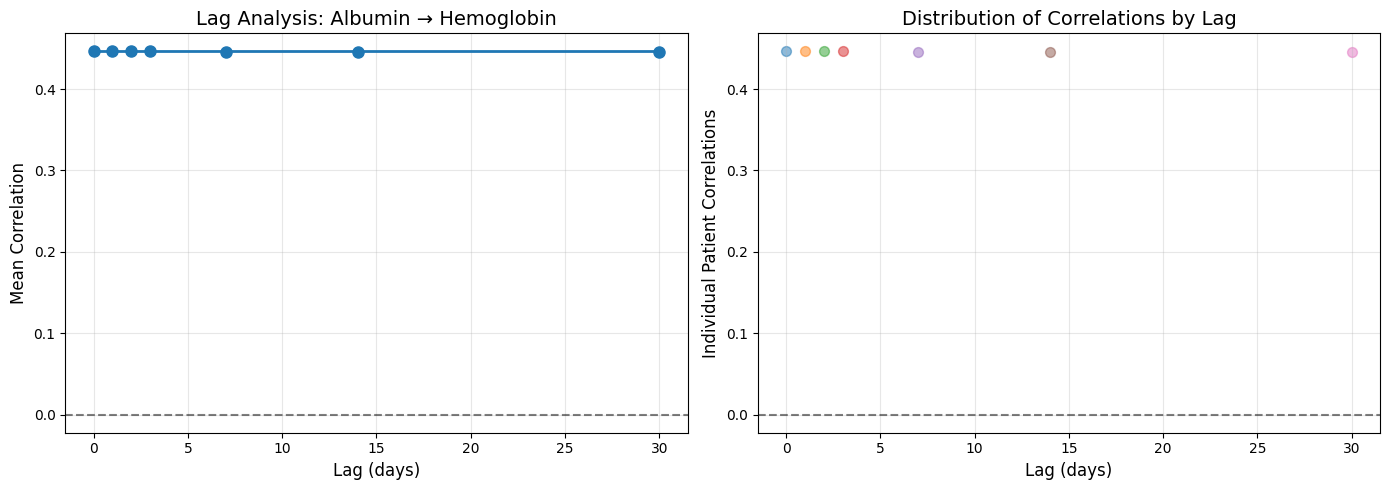


Lag analysis results saved to 'lag_analysis_results.csv'


In [6]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

d_labitems = pd.read_csv('d_labitems.csv')
labevents = pd.read_csv('labevents.csv')

albumin_items = d_labitems[d_labitems['label'].str.contains('Albumin', case=False, na=False)]
hemoglobin_items = d_labitems[d_labitems['label'].str.contains('Hemoglobin', case=False, na=False)]

albumin_ids = albumin_items['itemid'].tolist()
hemoglobin_ids = hemoglobin_items['itemid'].tolist()

albumin_data = labevents[labevents['itemid'].isin(albumin_ids)].copy()
albumin_data = albumin_data[['subject_id', 'charttime', 'valuenum']].dropna()
albumin_data['charttime'] = pd.to_datetime(albumin_data['charttime'])
albumin_data = albumin_data.rename(columns={'valuenum': 'albumin'})

hemoglobin_data = labevents[labevents['itemid'].isin(hemoglobin_ids)].copy()
hemoglobin_data = hemoglobin_data[['subject_id', 'charttime', 'valuenum']].dropna()
hemoglobin_data['charttime'] = pd.to_datetime(hemoglobin_data['charttime'])
hemoglobin_data = hemoglobin_data.rename(columns={'valuenum': 'hemoglobin'})
albumin_data = albumin_data.groupby(['subject_id', 'charttime'])['albumin'].mean().reset_index()
hemoglobin_data = hemoglobin_data.groupby(['subject_id', 'charttime'])['hemoglobin'].mean().reset_index()

patients_with_albumin = set(albumin_data['subject_id'].unique())
patients_with_hemoglobin = set(hemoglobin_data['subject_id'].unique())
patients_with_both = patients_with_albumin.intersection(patients_with_hemoglobin)

albumin_data = albumin_data[albumin_data['subject_id'].isin(patients_with_both)]
hemoglobin_data = hemoglobin_data[hemoglobin_data['subject_id'].isin(patients_with_both)]

measurement_counts_alb = albumin_data.groupby('subject_id').size()
measurement_counts_hgb = hemoglobin_data.groupby('subject_id').size()

repeated_patients_alb = set(measurement_counts_alb[measurement_counts_alb >= 3].index)
repeated_patients_hgb = set(measurement_counts_hgb[measurement_counts_hgb >= 3].index)
repeated_patients = repeated_patients_alb.intersection(repeated_patients_hgb)


print(f"LAG ANALYSIS: ALBUMIN PREDICTING FUTURE HEMOGLOBIN")
print(f"Patients with 3+ measurements of both markers: {len(repeated_patients)}")

MAX_LAG_DAYS = [0, 1, 2, 3, 7, 14, 30]

all_lag_results = []

for patient_id in repeated_patients:
    patient_albumin = albumin_data[albumin_data['subject_id'] == patient_id].sort_values('charttime')
    patient_hemoglobin = hemoglobin_data[hemoglobin_data['subject_id'] == patient_id].sort_values('charttime')

    if len(patient_albumin) >= 3 and len(patient_hemoglobin) >= 3:

        min_date = min(patient_albumin['charttime'].min(), patient_hemoglobin['charttime'].min())
        max_date = max(patient_albumin['charttime'].max(), patient_hemoglobin['charttime'].max())

        date_range = pd.date_range(start=min_date, end=max_date, freq='D')

        alb_series = patient_albumin.set_index('charttime')['albumin'].reindex(date_range)
        alb_series = alb_series.interpolate(method='time').fillna(method='bfill').fillna(method='ffill')

        hgb_series = patient_hemoglobin.set_index('charttime')['hemoglobin'].reindex(date_range)
        hgb_series = hgb_series.interpolate(method='time').fillna(method='bfill').fillna(method='ffill')

        alb_diff = alb_series.diff().dropna()
        hgb_diff = hgb_series.diff().dropna()

        for lag_days in MAX_LAG_DAYS:
            if lag_days == 0:
                alb_lag = alb_diff
                hgb = hgb_diff
            else:
                alb_lag = alb_diff.iloc[:-lag_days]
                hgb = hgb_diff.iloc[lag_days:]

            common_idx = alb_lag.index.intersection(hgb.index)
            alb_aligned = alb_lag[common_idx]
            hgb_aligned = hgb[common_idx]

            n = len(alb_aligned)

            if n >= 5 and alb_aligned.std() > 0 and hgb_aligned.std() > 0:
                try:
                    r, p = stats.pearsonr(alb_aligned, hgb_aligned)
                    all_lag_results.append({
                        'patient_id': patient_id,
                        'lag_days': lag_days,
                        'n': n,
                        'r': r,
                        'p': p,
                        'significant': p < 0.05
                    })
                except:
                    pass

if len(all_lag_results) > 0:
    df_lag_results = pd.DataFrame(all_lag_results)

    print(f"AGGREGATE LAG ANALYSIS (ACROSS ALL PATIENTS)")

    print(f"{'Lag (days)':<12} {'N (pairs)':<10} {'r':<10} {'p-value':<12} {'Result'}")


    for lag in MAX_LAG_DAYS:
        lag_data = df_lag_results[df_lag_results['lag_days'] == lag]

        if len(lag_data) > 0:
            mean_r = lag_data['r'].mean()
            median_r = lag_data['r'].median()

            all_r_values = lag_data['r'].values
            all_p_values = lag_data['p'].values

            n_total = lag_data['n'].sum()
            n_significant = (lag_data['p'] < 0.05).sum()

            t_stat, p_value = stats.ttest_1samp(all_r_values, 0)

            sig = "Significant" if p_value < 0.05 else "Not Significant"
            p_str = f"{p_value:.2e}" if p_value >= 0.001 else "< 0.001"

            print(f"{lag:<12} {n_total:<10} {mean_r:<10.3f} {p_str:<12} {sig}")
            print(f"{'':12} Median r={median_r:.3f}, {n_significant}/{len(lag_data)} patients significant")


    print(f"INTERPRETATION")

    lag_0_data = df_lag_results[df_lag_results['lag_days'] == 0]
    if len(lag_0_data) > 0:
        lag_0_mean = lag_0_data['r'].mean()
        print(f"Concurrent correlation (lag=0): r={lag_0_mean:.3f}")

    best_lag = df_lag_results.groupby('lag_days')['r'].mean().abs().idxmax()
    best_r = df_lag_results.groupby('lag_days')['r'].mean()[best_lag]
    print(f"Strongest correlation at lag: {best_lag} days (r={best_r:.3f})")

    all_lags_similar = df_lag_results.groupby('lag_days')['r'].mean().std() < 0.05

    if all_lags_similar:
        print(f"\nConclusion: Albumin-hemoglobin show a STABLE correlation (r≈{best_r:.3f}).")
        print("This indicates a persistent physiological relationship, not a temporal cause-effect.")
        print("Both markers reflect the same underlying state (inflammation/nutritional status).")
        print("\nClinical value: Albumin can be used as a reliable marker for anemia risk")
        print("assessment, as the correlation remains stable over time.")
    elif best_lag == 0:
        print("\nConclusion: Albumin-hemoglobin relationship is CONCURRENT.")
        print("Changes happen together, indicating they reflect the same physiological state.")
    else:
        print(f"\nConclusion: Albumin changes show strongest correlation with hemoglobin")
        print(f"changes {best_lag} days later, suggesting temporal dynamics.")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    lag_summary = df_lag_results.groupby('lag_days').agg({
        'r': ['mean', 'median', 'std'],
        'n': 'sum'
    }).reset_index()

    axes[0].errorbar(lag_summary['lag_days'],
                     lag_summary[('r', 'mean')],
                     yerr=lag_summary[('r', 'std')],
                     marker='o', linewidth=2, markersize=8, capsize=5)
    axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[0].set_xlabel('Lag (days)', fontsize=12)
    axes[0].set_ylabel('Mean Correlation', fontsize=12)
    axes[0].set_title('Lag Analysis: Albumin → Hemoglobin', fontsize=14)
    axes[0].grid(True, alpha=0.3)

    for lag in MAX_LAG_DAYS:
        lag_data = df_lag_results[df_lag_results['lag_days'] == lag]
        if len(lag_data) > 0:
            axes[1].scatter([lag] * len(lag_data), lag_data['r'], alpha=0.5, s=50)

    axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1].set_xlabel('Lag (days)', fontsize=12)
    axes[1].set_ylabel('Individual Patient Correlations', fontsize=12)
    axes[1].set_title('Distribution of Correlations by Lag', fontsize=14)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    df_lag_results.to_csv('lag_analysis_results.csv', index=False)
    print(f"\nLag analysis results saved to 'lag_analysis_results.csv'")

else:
    print("\nNo sufficient data for lag analysis.")

IDENTIFYING BIOMARKERS IN MIMIC-IV

ALBUMIN items found: 21
     itemid           label
8     52022  Albumin, Blood
331   53138       (Albumin)
344   50862         Albumin

HEMOGLOBIN items found: 25
    itemid              label
23   50811         Hemoglobin
28   50814      Methemoglobin
41   52032  P50 of Hemoglobin

WBC items found: 11
     itemid               label
72    51755   White Blood Cells
107   51756   White Blood Cells
412   53134  Absolute Other WBC

HEMATOCRIT items found: 11
     itemid                   label
5     50810  Hematocrit, Calculated
11    52028              Hematocrit
206   51638              Hematocrit

CRP items found: 2
     itemid                 label
367   51652  High-Sensitivity CRP
415   50889    C-Reactive Protein

PLATELET items found: 8
     itemid                 label
243   51704        Platelet Count
902   52159  Platelet Aggregation
978   51240       Large Platelets

NEUTROPHIL items found: 13
      itemid                                 lab

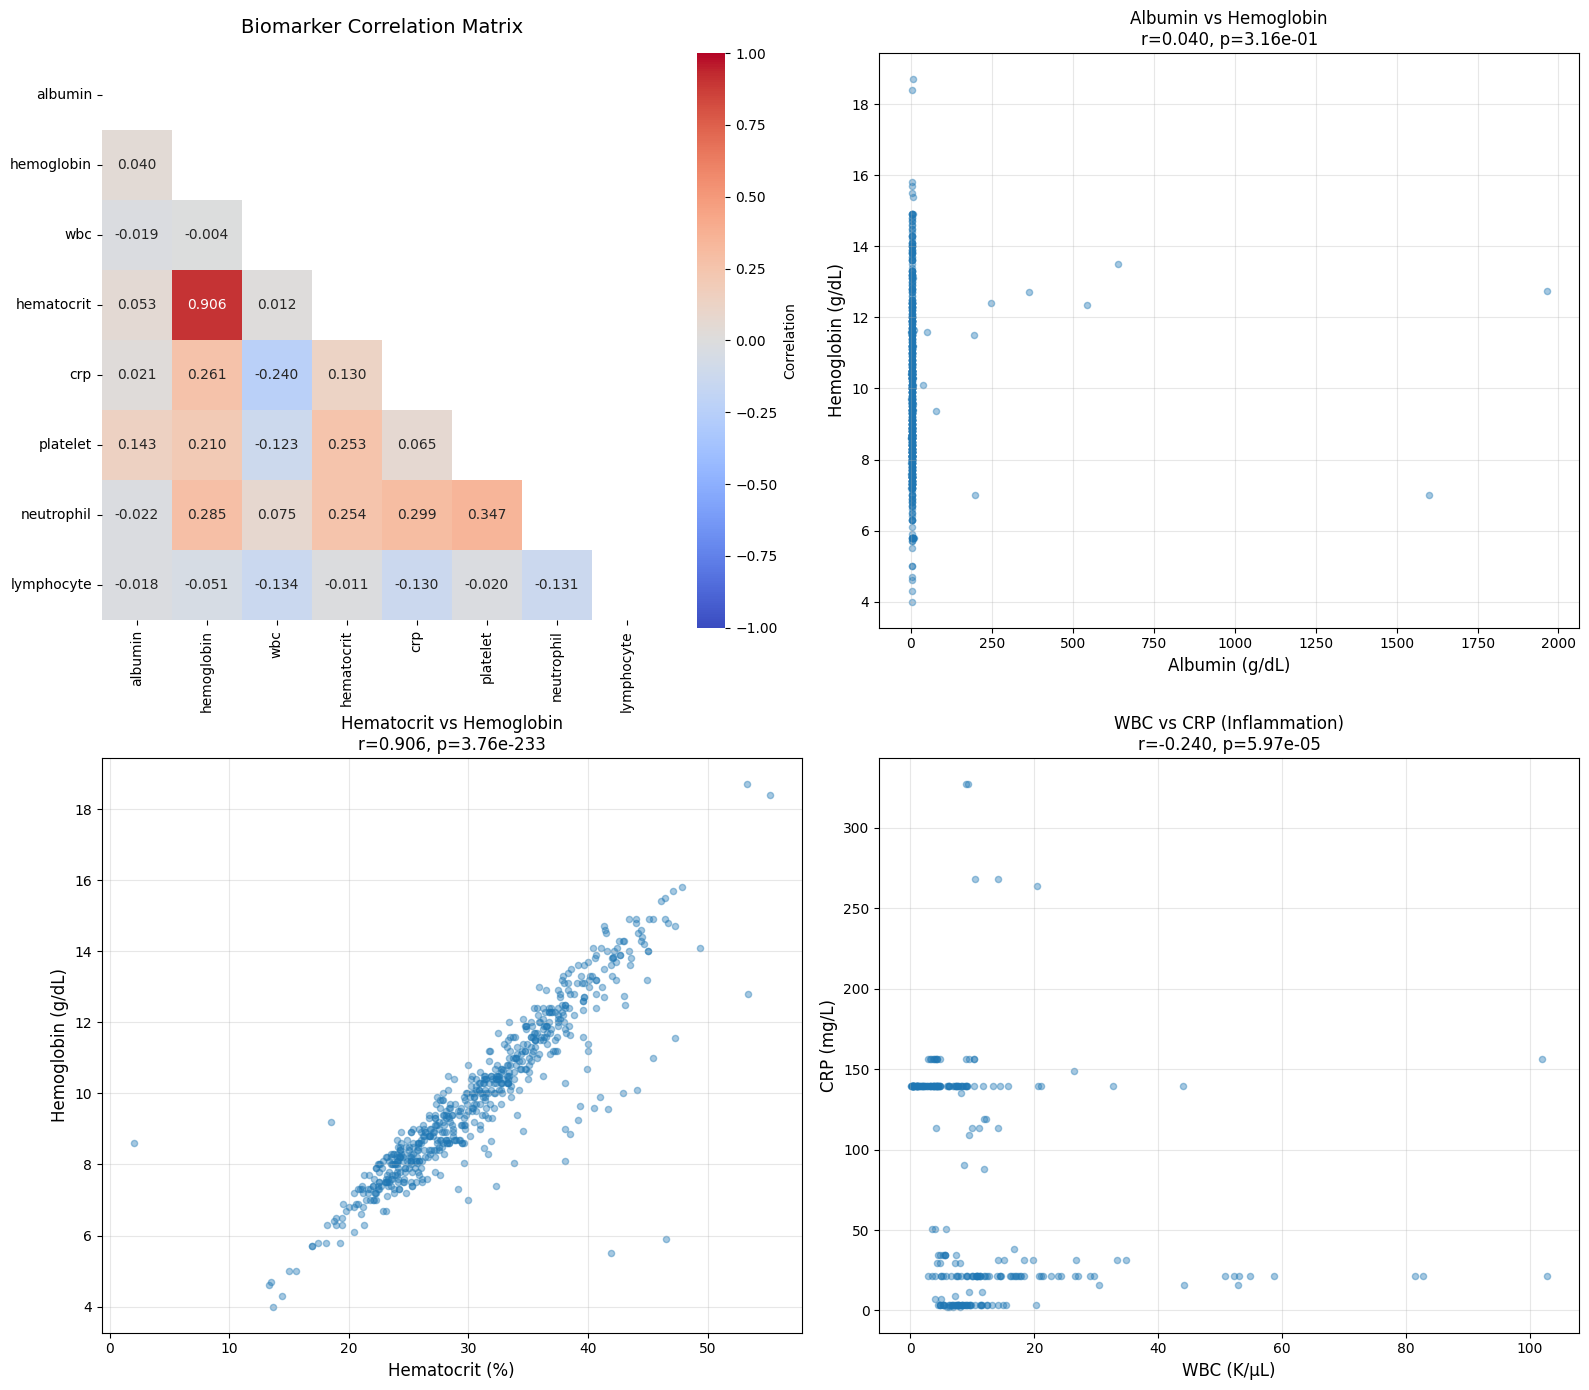

SUMMARY
Analyzed 53 patients with temporal biomarker data
Total measurements: 629
Biomarkers analyzed: 8

Top 3 strongest correlations with hemoglobin:
1. hematocrit: r=0.906
2. neutrophil: r=0.285
3. crp: r=0.261

Files saved:
  - multi_biomarker_temporal_data.csv
  - biomarker_correlation_matrix.csv


In [4]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

d_labitems = pd.read_csv('d_labitems.csv')
labevents = pd.read_csv('labevents.csv')

biomarkers = {
    'albumin': 'Albumin',
    'hemoglobin': 'Hemoglobin',
    'wbc': 'White Blood Cells|WBC',
    'hematocrit': 'Hematocrit',
    'crp': 'C-Reactive Protein|CRP',
    'platelet': 'Platelet',
    'neutrophil': 'Neutrophil',
    'lymphocyte': 'Lymphocyte'
}

biomarker_ids = {}
print(f"IDENTIFYING BIOMARKERS IN MIMIC-IV")

for key, pattern in biomarkers.items():
    items = d_labitems[d_labitems['label'].str.contains(pattern, case=False, na=False, regex=True)]
    print(f"\n{key.upper()} items found: {len(items)}")
    if len(items) > 0:
        print(items[['itemid', 'label']].head(3))
        biomarker_ids[key] = items['itemid'].tolist()

biomarker_data = {}
for key, item_ids in biomarker_ids.items():
    data = labevents[labevents['itemid'].isin(item_ids)].copy()
    data = data[['subject_id', 'charttime', 'valuenum']].dropna()
    data['charttime'] = pd.to_datetime(data['charttime'])
    data = data.groupby(['subject_id', 'charttime'])['valuenum'].mean().reset_index()
    data = data.rename(columns={'valuenum': key})
    biomarker_data[key] = data
    print(f"{key}: {len(data)} measurements, {data['subject_id'].nunique()} patients")

TIME_WINDOW = pd.Timedelta('7d')

base_data = biomarker_data['albumin'].copy()
merged = base_data

for key in ['hemoglobin', 'wbc', 'hematocrit', 'crp', 'platelet', 'neutrophil', 'lymphocyte']:
    if key in biomarker_data and len(biomarker_data[key]) > 0:
        merged = pd.merge_asof(
            merged.sort_values('charttime'),
            biomarker_data[key].sort_values('charttime'),
            on='charttime',
            by='subject_id',
            tolerance=TIME_WINDOW,
            direction='nearest',
            suffixes=('', f'_{key}')
        )

for col in merged.columns:
    if col not in ['subject_id', 'charttime']:
        merged[col] = merged.groupby('subject_id')[col].transform(
            lambda x: x.fillna(x.mean())
        )

measurement_counts = merged.groupby('subject_id').size()
repeated_patients = measurement_counts[measurement_counts >= 2].index
temporal_data = merged[merged['subject_id'].isin(repeated_patients)].copy()

temporal_data = temporal_data.sort_values(['subject_id', 'charttime'])

available_biomarkers = [col for col in temporal_data.columns if col not in ['subject_id', 'charttime']]

print(f"MULTI-BIOMARKER TEMPORAL ANALYSIS")
print(f"Total patients with repeated measurements: {len(repeated_patients)}")
print(f"Total temporal measurements: {len(temporal_data)}")
print(f"\nAvailable biomarkers: {available_biomarkers}")

print(f"\nData completeness:")
for col in available_biomarkers:
    missing_pct = (temporal_data[col].isna().sum() / len(temporal_data)) * 100
    complete_pct = 100 - missing_pct
    print(f"  {col}: {complete_pct:.1f}% complete")

temporal_data_clean = temporal_data.dropna(subset=available_biomarkers, how='all')

correlation_matrix = temporal_data_clean[available_biomarkers].corr()

print(f"CORRELATION MATRIX")
print(correlation_matrix.round(3))

print(f"KEY CORRELATIONS WITH HEMOGLOBIN")

if 'hemoglobin' in available_biomarkers:
    hgb_corr = correlation_matrix['hemoglobin'].drop('hemoglobin').sort_values(ascending=False)
    for biomarker, r in hgb_corr.items():
        valid_data = temporal_data_clean[[biomarker, 'hemoglobin']].dropna()
        if len(valid_data) >= 10:
            r_val, p_val = pearsonr(valid_data[biomarker], valid_data['hemoglobin'])
            sig = "SIGNIFICANT" if p_val < 0.05 else "Not significant"
            print(f"{biomarker:15} vs hemoglobin: r={r_val:6.3f}, p={p_val:.2e}, n={len(valid_data):4}, {sig}")

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1, mask=mask, square=True, ax=axes[0, 0],
            cbar_kws={'label': 'Correlation'})
axes[0, 0].set_title('Biomarker Correlation Matrix', fontsize=14, pad=20)

if 'hemoglobin' in available_biomarkers and 'albumin' in available_biomarkers:
    data_plot = temporal_data_clean[['albumin', 'hemoglobin']].dropna()
    axes[0, 1].scatter(data_plot['albumin'], data_plot['hemoglobin'], alpha=0.4, s=20)
    axes[0, 1].set_xlabel('Albumin (g/dL)', fontsize=12)
    axes[0, 1].set_ylabel('Hemoglobin (g/dL)', fontsize=12)
    r, p = pearsonr(data_plot['albumin'], data_plot['hemoglobin'])
    axes[0, 1].set_title(f'Albumin vs Hemoglobin\nr={r:.3f}, p={p:.2e}', fontsize=12)
    axes[0, 1].grid(True, alpha=0.3)

if 'hematocrit' in available_biomarkers and 'hemoglobin' in available_biomarkers:
    data_plot = temporal_data_clean[['hematocrit', 'hemoglobin']].dropna()
    axes[1, 0].scatter(data_plot['hematocrit'], data_plot['hemoglobin'], alpha=0.4, s=20)
    axes[1, 0].set_xlabel('Hematocrit (%)', fontsize=12)
    axes[1, 0].set_ylabel('Hemoglobin (g/dL)', fontsize=12)
    r, p = pearsonr(data_plot['hematocrit'], data_plot['hemoglobin'])
    axes[1, 0].set_title(f'Hematocrit vs Hemoglobin\nr={r:.3f}, p={p:.2e}', fontsize=12)
    axes[1, 0].grid(True, alpha=0.3)

if 'wbc' in available_biomarkers and 'crp' in available_biomarkers:
    data_plot = temporal_data_clean[['wbc', 'crp']].dropna()
    if len(data_plot) > 10:
        axes[1, 1].scatter(data_plot['wbc'], data_plot['crp'], alpha=0.4, s=20)
        axes[1, 1].set_xlabel('WBC (K/μL)', fontsize=12)
        axes[1, 1].set_ylabel('CRP (mg/L)', fontsize=12)
        r, p = pearsonr(data_plot['wbc'], data_plot['crp'])
        axes[1, 1].set_title(f'WBC vs CRP (Inflammation)\nr={r:.3f}, p={p:.2e}', fontsize=12)
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'Insufficient CRP data',
                       ha='center', va='center', transform=axes[1, 1].transAxes)
else:
    axes[1, 1].text(0.5, 0.5, 'WBC or CRP data not available',
                   ha='center', va='center', transform=axes[1, 1].transAxes)

plt.tight_layout()
plt.show()

temporal_data_clean.to_csv('multi_biomarker_temporal_data.csv', index=False)
correlation_matrix.to_csv('biomarker_correlation_matrix.csv')

print(f"SUMMARY")

print(f"Analyzed {len(repeated_patients)} patients with temporal biomarker data")
print(f"Total measurements: {len(temporal_data_clean)}")
print(f"Biomarkers analyzed: {len(available_biomarkers)}")

print(f"\nTop 3 strongest correlations with hemoglobin:")
if 'hemoglobin' in available_biomarkers:
    hgb_corr_sorted = correlation_matrix['hemoglobin'].drop('hemoglobin').abs().sort_values(ascending=False)
    for i, (biomarker, abs_r) in enumerate(hgb_corr_sorted.head(3).items(), 1):
        r = correlation_matrix.loc[biomarker, 'hemoglobin']
        print(f"{i}. {biomarker}: r={r:.3f}")

print(f"\nFiles saved:")
print(f"  - multi_biomarker_temporal_data.csv")
print(f"  - biomarker_correlation_matrix.csv")


FERRITIN items found:
     itemid     label
403   50924  Ferritin

Albumin: 657 measurements, 81 patients
Hemoglobin: 2969 measurements, 100 patients
Ferritin: 76 measurements, 32 patients
ALBUMIN-HEMOGLOBIN-FERRITIN ANALYSIS
Patients with all three markers: 29
Total measurements: 512
CORRELATIONS
Albumin vs Hemoglobin: r=0.051, p=2.49e-01
Albumin vs Ferritin:   r=-0.051, p=2.51e-01
Hemoglobin vs Ferritin: r=0.132, p=2.84e-03


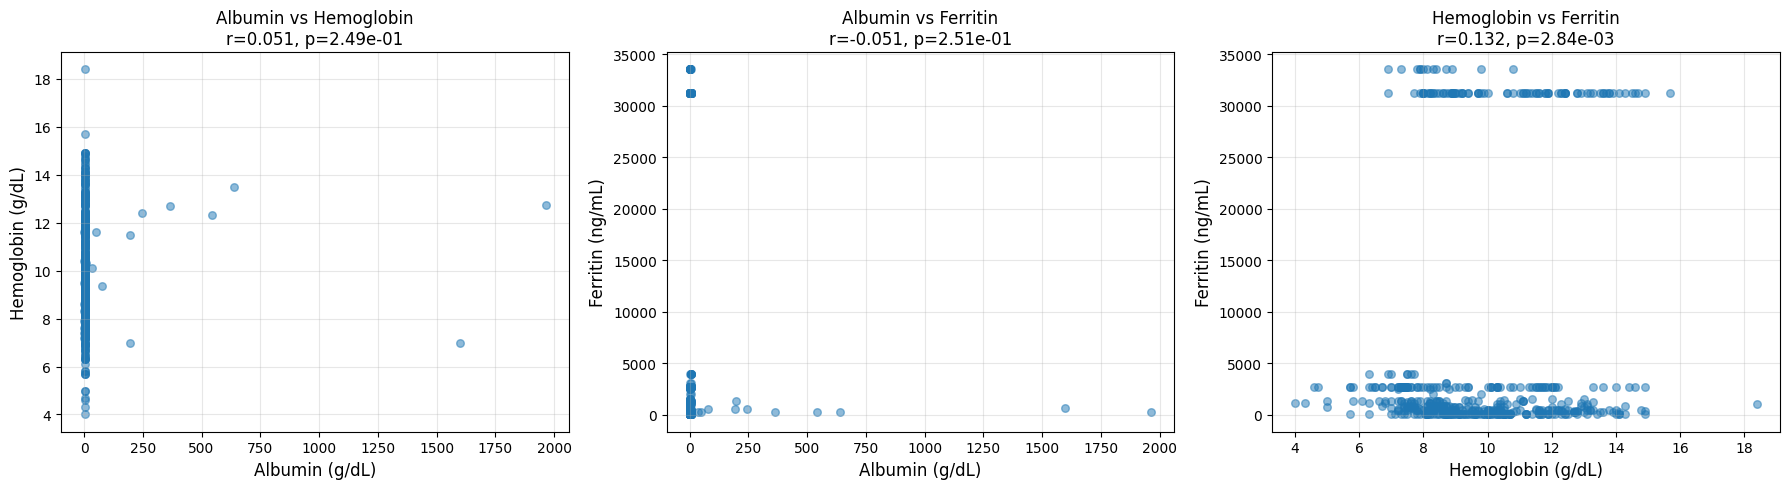

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

d_labitems = pd.read_csv('d_labitems.csv')
labevents = pd.read_csv('labevents.csv')

# Check for ferritin
ferritin_items = d_labitems[d_labitems['label'].str.contains('Ferritin', case=False, na=False)]
print("FERRITIN items found:")
print(ferritin_items[['itemid', 'label']])

if len(ferritin_items) > 0:
    ferritin_ids = ferritin_items['itemid'].tolist()

    albumin_items = d_labitems[d_labitems['label'].str.contains('Albumin', case=False, na=False)]
    hemoglobin_items = d_labitems[d_labitems['label'].str.contains('Hemoglobin', case=False, na=False)]

    albumin_ids = albumin_items['itemid'].tolist()
    hemoglobin_ids = hemoglobin_items['itemid'].tolist()

    albumin_data = labevents[labevents['itemid'].isin(albumin_ids)].copy()
    albumin_data = albumin_data[['subject_id', 'charttime', 'valuenum']].dropna()
    albumin_data['charttime'] = pd.to_datetime(albumin_data['charttime'])
    albumin_data = albumin_data.groupby(['subject_id', 'charttime'])['valuenum'].mean().reset_index()
    albumin_data = albumin_data.rename(columns={'valuenum': 'albumin'})

    hemoglobin_data = labevents[labevents['itemid'].isin(hemoglobin_ids)].copy()
    hemoglobin_data = hemoglobin_data[['subject_id', 'charttime', 'valuenum']].dropna()
    hemoglobin_data['charttime'] = pd.to_datetime(hemoglobin_data['charttime'])
    hemoglobin_data = hemoglobin_data.groupby(['subject_id', 'charttime'])['valuenum'].mean().reset_index()
    hemoglobin_data = hemoglobin_data.rename(columns={'valuenum': 'hemoglobin'})

    ferritin_data = labevents[labevents['itemid'].isin(ferritin_ids)].copy()
    ferritin_data = ferritin_data[['subject_id', 'charttime', 'valuenum']].dropna()
    ferritin_data['charttime'] = pd.to_datetime(ferritin_data['charttime'])
    ferritin_data = ferritin_data.groupby(['subject_id', 'charttime'])['valuenum'].mean().reset_index()
    ferritin_data = ferritin_data.rename(columns={'valuenum': 'ferritin'})

    print(f"\nAlbumin: {len(albumin_data)} measurements, {albumin_data['subject_id'].nunique()} patients")
    print(f"Hemoglobin: {len(hemoglobin_data)} measurements, {hemoglobin_data['subject_id'].nunique()} patients")
    print(f"Ferritin: {len(ferritin_data)} measurements, {ferritin_data['subject_id'].nunique()} patients")

    # Merge with 7-day window
    TIME_WINDOW = pd.Timedelta('7d')

    merged = pd.merge_asof(
        albumin_data.sort_values('charttime'),
        hemoglobin_data.sort_values('charttime'),
        on='charttime',
        by='subject_id',
        tolerance=TIME_WINDOW,
        direction='nearest'
    )

    merged = pd.merge_asof(
        merged.sort_values('charttime'),
        ferritin_data.sort_values('charttime'),
        on='charttime',
        by='subject_id',
        tolerance=TIME_WINDOW,
        direction='nearest'
    )

    # Fill missing with patient mean
    for col in ['albumin', 'hemoglobin', 'ferritin']:
        merged[col] = merged.groupby('subject_id')[col].transform(
            lambda x: x.fillna(x.mean())
        )

    data_clean = merged.dropna(subset=['albumin', 'hemoglobin', 'ferritin'])

    print(f"ALBUMIN-HEMOGLOBIN-FERRITIN ANALYSIS")
    print(f"Patients with all three markers: {data_clean['subject_id'].nunique()}")
    print(f"Total measurements: {len(data_clean)}")

    print(f"CORRELATIONS")

    r_alb_hgb, p_alb_hgb = pearsonr(data_clean['albumin'], data_clean['hemoglobin'])
    print(f"Albumin vs Hemoglobin: r={r_alb_hgb:.3f}, p={p_alb_hgb:.2e}")

    r_alb_fer, p_alb_fer = pearsonr(data_clean['albumin'], data_clean['ferritin'])
    print(f"Albumin vs Ferritin:   r={r_alb_fer:.3f}, p={p_alb_fer:.2e}")

    r_hgb_fer, p_hgb_fer = pearsonr(data_clean['hemoglobin'], data_clean['ferritin'])
    print(f"Hemoglobin vs Ferritin: r={r_hgb_fer:.3f}, p={p_hgb_fer:.2e}")

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].scatter(data_clean['albumin'], data_clean['hemoglobin'], alpha=0.5, s=30)
    axes[0].set_xlabel('Albumin (g/dL)', fontsize=12)
    axes[0].set_ylabel('Hemoglobin (g/dL)', fontsize=12)
    axes[0].set_title(f'Albumin vs Hemoglobin\nr={r_alb_hgb:.3f}, p={p_alb_hgb:.2e}', fontsize=12)
    axes[0].grid(True, alpha=0.3)

    axes[1].scatter(data_clean['albumin'], data_clean['ferritin'], alpha=0.5, s=30)
    axes[1].set_xlabel('Albumin (g/dL)', fontsize=12)
    axes[1].set_ylabel('Ferritin (ng/mL)', fontsize=12)
    axes[1].set_title(f'Albumin vs Ferritin\nr={r_alb_fer:.3f}, p={p_alb_fer:.2e}', fontsize=12)
    axes[1].grid(True, alpha=0.3)

    axes[2].scatter(data_clean['hemoglobin'], data_clean['ferritin'], alpha=0.5, s=30)
    axes[2].set_xlabel('Hemoglobin (g/dL)', fontsize=12)
    axes[2].set_ylabel('Ferritin (ng/mL)', fontsize=12)
    axes[2].set_title(f'Hemoglobin vs Ferritin\nr={r_hgb_fer:.3f}, p={p_hgb_fer:.2e}', fontsize=12)
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    data_clean.to_csv('albumin_hemoglobin_ferritin_data.csv', index=False)

else:
    print("\nNo ferritin data found in this dataset")

In [17]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

d_labitems = pd.read_csv('d_labitems.csv')
labevents = pd.read_csv('labevents.csv')

biomarkers = {
    'albumin': 'Albumin',
    'hemoglobin': 'Hemoglobin',
    'wbc': 'White Blood Cells|WBC',
    'hematocrit': 'Hematocrit',
    'crp': 'C-Reactive Protein|CRP',
    'platelet': 'Platelet',
    'neutrophil': 'Neutrophil',
    'lymphocyte': 'Lymphocyte',
    'ferritin': 'Ferritin'
}

biomarker_ids = {}
print(f"EXTRACTING ALL BIOMARKERS ")

for key, pattern in biomarkers.items():
    items = d_labitems[d_labitems['label'].str.contains(pattern, case=False, na=False, regex=True)]
    print(f"\n{key.upper()}: {len(items)} item IDs found")
    if len(items) > 0:
        biomarker_ids[key] = items['itemid'].tolist()

biomarker_data = {}

for key, item_ids in biomarker_ids.items():
    data = labevents[labevents['itemid'].isin(item_ids)].copy()
    data = data[['subject_id', 'charttime', 'valuenum']].dropna()
    data['charttime'] = pd.to_datetime(data['charttime'])
    data = data.groupby(['subject_id', 'charttime'])['valuenum'].mean().reset_index()
    data = data.rename(columns={'valuenum': key})
    biomarker_data[key] = data
    print(f"{key:15} {len(data):5} measurements, {data['subject_id'].nunique():3} patients")

TIME_WINDOW = pd.Timedelta('168h')  # 7 days

print(f"MERGING BIOMARKERS (7-day tolerance window)")

base_data = biomarker_data['albumin'].copy()
merged = base_data

merge_order = ['hemoglobin', 'wbc', 'hematocrit', 'crp', 'platelet', 'neutrophil', 'lymphocyte', 'ferritin']

for key in merge_order:
    if key in biomarker_data and len(biomarker_data[key]) > 0:
        print(f"Merging {key}")
        merged = pd.merge_asof(
            merged.sort_values('charttime'),
            biomarker_data[key].sort_values('charttime'),
            on='charttime',
            by='subject_id',
            tolerance=TIME_WINDOW,
            direction='nearest',
            suffixes=('', f'_{key}')
        )

for col in merged.columns:
    if col not in ['subject_id', 'charttime']:
        merged[col] = merged.groupby('subject_id')[col].transform(
            lambda x: x.fillna(x.mean())
        )

measurement_counts = merged.groupby('subject_id').size()
repeated_patients = measurement_counts[measurement_counts >= 2].index
temporal_data = merged[merged['subject_id'].isin(repeated_patients)].copy()

temporal_data = temporal_data.sort_values(['subject_id', 'charttime'])

available_biomarkers = [col for col in temporal_data.columns if col not in ['subject_id', 'charttime']]

print(f"FINAL DATASET SUMMARY")
print(f"Total patients: {len(repeated_patients)}")
print(f"Total measurements: {len(temporal_data)}")
print(f"Available biomarkers: {len(available_biomarkers)}")

print(f"\nBiomarkers included: {available_biomarkers}")

print(f"\nData completeness:")
for col in available_biomarkers:
    missing_pct = (temporal_data[col].isna().sum() / len(temporal_data)) * 100
    complete_pct = 100 - missing_pct
    non_missing = temporal_data[col].notna().sum()
    print(f"  {col:15} {complete_pct:5.1f}% complete ({non_missing:4} non-missing values)")

temporal_data.to_csv('complete_biomarker_dataset_with_ferritin.csv', index=False)

print(f"SAVED: complete_biomarker_dataset_with_ferritin.csv")

EXTRACTING ALL BIOMARKERS 

ALBUMIN: 21 item IDs found

HEMOGLOBIN: 25 item IDs found

WBC: 11 item IDs found

HEMATOCRIT: 11 item IDs found

CRP: 2 item IDs found

PLATELET: 8 item IDs found

NEUTROPHIL: 13 item IDs found

LYMPHOCYTE: 16 item IDs found

FERRITIN: 1 item IDs found
albumin           657 measurements,  81 patients
hemoglobin       2969 measurements, 100 patients
wbc              2936 measurements, 100 patients
hematocrit       3047 measurements, 100 patients
crp                42 measurements,  19 patients
platelet         2818 measurements, 100 patients
neutrophil        939 measurements,  91 patients
lymphocyte        984 measurements,  92 patients
ferritin           76 measurements,  32 patients
MERGING BIOMARKERS (7-day tolerance window)
Merging hemoglobin
Merging wbc
Merging hematocrit
Merging crp
Merging platelet
Merging neutrophil
Merging lymphocyte
Merging ferritin
FINAL DATASET SUMMARY
Total patients: 53
Total measurements: 629
Available biomarkers: 9

Biomarker

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('complete_biomarker_dataset_with_ferritin.csv')

print(f"XGBOOST ANEMIA PREDICTION MODEL")
print(f"Total records: {len(data)}")
print(f"Total patients: {data['subject_id'].nunique()}")

ANEMIA_THRESHOLD = 12.0

data['anemia'] = (data['hemoglobin'] < ANEMIA_THRESHOLD).astype(int)

anemia_count = data['anemia'].sum()
anemia_pct = (anemia_count / len(data)) * 100

XGBOOST ANEMIA PREDICTION MODEL
Total records: 629
Total patients: 53


In [7]:
print(f"\nAnemia prevalence (Hgb < {ANEMIA_THRESHOLD} g/dL):")
print(f"  Anemic: {anemia_count} ({anemia_pct:.1f}%)")
print(f"  Non-anemic: {len(data) - anemia_count} ({100-anemia_pct:.1f}%)")

feature_cols = [col for col in data.columns if col not in ['subject_id', 'charttime', 'hemoglobin', 'anemia']]

missing_pct = data[feature_cols].isna().mean() * 100
valid_features = missing_pct[missing_pct < 50].index.tolist()

print(f"\nFeatures for model: {valid_features}")



Anemia prevalence (Hgb < 12.0 g/dL):
  Anemic: 508 (80.8%)
  Non-anemic: 121 (19.2%)

Features for model: ['albumin', 'wbc', 'hematocrit', 'platelet', 'neutrophil', 'lymphocyte', 'ferritin']


In [8]:
X = data[valid_features].copy()
y = data['anemia'].copy()

for col in X.columns:
    X[col] = X[col].fillna(X[col].median())

mask = ~(X.isna().any(axis=1) | y.isna())
X = X[mask]
y = y[mask]

print(f"\nFinal dataset after cleaning:")
print(f"  Samples: {len(X)}")
print(f"  Features: {X.shape[1]}")
print(f"  Anemia cases: {y.sum()} ({y.sum()/len(y)*100:.1f}%)")


Final dataset after cleaning:
  Samples: 629
  Features: 7
  Anemia cases: 508 (80.8%)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {len(X_train)} samples ({y_train.sum()} anemic)")
print(f"Test set: {len(X_test)} samples ({y_test.sum()} anemic)")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)



Train set: 503 samples (406 anemic)
Test set: 126 samples (102 anemic)


In [10]:
scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

print(f"model Training")

# Train XGBoost model
model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

model.fit(X_train_scaled, y_train)

y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

y_pred_proba_train = model.predict_proba(X_train_scaled)[:, 1]
y_pred_proba_test = model.predict_proba(X_test_scaled)[:, 1]

print("\nTRAIN SET:")
print(classification_report(y_train, y_pred_train, target_names=['No Anemia', 'Anemia']))
train_auc = roc_auc_score(y_train, y_pred_proba_train)
print(f"ROC-AUC Score: {train_auc:.3f}")

print("\nTEST SET:")
print(classification_report(y_test, y_pred_test, target_names=['No Anemia', 'Anemia']))
test_auc = roc_auc_score(y_test, y_pred_proba_test)
print(f"ROC-AUC Score: {test_auc:.3f}")

model Training

TRAIN SET:
              precision    recall  f1-score   support

   No Anemia       0.86      1.00      0.92        97
      Anemia       1.00      0.96      0.98       406

    accuracy                           0.97       503
   macro avg       0.93      0.98      0.95       503
weighted avg       0.97      0.97      0.97       503

ROC-AUC Score: 0.998

TEST SET:
              precision    recall  f1-score   support

   No Anemia       0.73      0.92      0.81        24
      Anemia       0.98      0.92      0.95       102

    accuracy                           0.92       126
   macro avg       0.86      0.92      0.88       126
weighted avg       0.93      0.92      0.92       126

ROC-AUC Score: 0.978


In [11]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"FEATURE IMPORTANCE (TOP 5)")
for idx, row in feature_importance.head(5).iterrows():
    print(f"{row['feature']:15} {row['importance']:.3f}")


FEATURE IMPORTANCE (TOP 5)
hematocrit      0.683
ferritin        0.077
platelet        0.075
neutrophil      0.060
lymphocyte      0.039


SHAP EXPLAINABILITY ANALYSIS


Text(0.5, 770.0555555555557, 'Predicted Label')

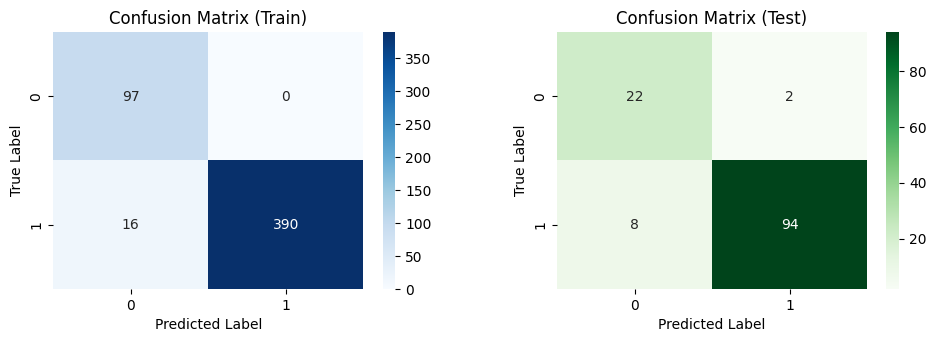

In [12]:
print(f"SHAP EXPLAINABILITY ANALYSIS")

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

#  Confusion Matrix - Train
ax1 = fig.add_subplot(gs[0, 0])
cm_train = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Confusion Matrix (Train)', fontsize=12)
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

#  Confusion Matrix - Test
ax2 = fig.add_subplot(gs[0, 1])
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=ax2)
ax2.set_title('Confusion Matrix (Test)', fontsize=12)
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')



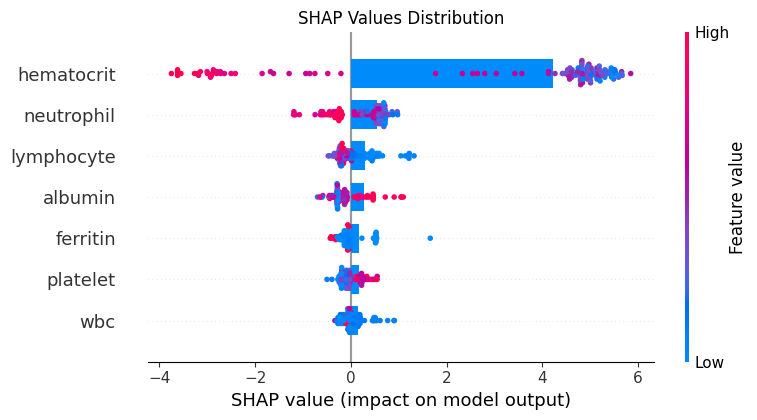

In [13]:
ax3 = fig.add_subplot(gs[0, 2])
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
ax3.plot(fpr_train, tpr_train, label=f'Train (AUC={train_auc:.3f})', linewidth=2)
ax3.plot(fpr_test, tpr_test, label=f'Test (AUC={test_auc:.3f})', linewidth=2)
ax3.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC Curve')
ax3.legend()
ax3.grid(True, alpha=0.3)

#  Feature Importance
ax4 = fig.add_subplot(gs[1, :])
top_features = feature_importance.head(10)
ax4.barh(range(len(top_features)), top_features['importance'])
ax4.set_yticks(range(len(top_features)))
ax4.set_yticklabels(top_features['feature'])
ax4.set_xlabel('Importance')
ax4.set_title('Top 10 Feature Importance (XGBoost)', fontsize=12)
ax4.grid(True, alpha=0.3, axis='x')

# SHAP Summary Plot
ax5 = fig.add_subplot(gs[2, :2])
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", show=False, max_display=10)
plt.title('SHAP Feature Importance', fontsize=12)

#  SHAP Detailed Plot
ax6 = fig.add_subplot(gs[2, 2])
shap.summary_plot(shap_values, X_test_scaled, show=False, max_display=8)
plt.title('SHAP Values Distribution', fontsize=12)

plt.savefig('xgboost_anemia_model_results.png', dpi=300, bbox_inches='tight')
plt.show()


In [14]:
results_df = pd.DataFrame({
    'true_label': y_test.values,
    'predicted_label': y_pred_test,
    'anemia_probability': y_pred_proba_test
})

for col in X_test.columns:
    results_df[col] = X_test[col].values

results_df.to_csv('xgboost_predictions.csv', index=False)

feature_importance.to_csv('feature_importance.csv', index=False)

print(f"SUMMARY")
print(f"Model trained on {len(X_train)} samples")
print(f"Test set performance: AUC = {test_auc:.3f}")
print(f"\nTop 3 most important features:")
for idx, row in feature_importance.head(3).iterrows():
    print(f"  {idx+1}. {row['feature']}: {row['importance']:.3f}")

print(f"\nFiles saved:")
print(f"  - xgboost_anemia_model_results.png")
print(f"  - xgboost_predictions.csv")
print(f"  - feature_importance.csv")


SUMMARY
Model trained on 503 samples
Test set performance: AUC = 0.978

Top 3 most important features:
  3. hematocrit: 0.683
  7. ferritin: 0.077
  4. platelet: 0.075

Files saved:
  - xgboost_anemia_model_results.png
  - xgboost_predictions.csv
  - feature_importance.csv


In [16]:
import pandas as pd

feature_importance = pd.read_csv('feature_importance.csv')

print(f"Full FEATURE IMPORTANCE List")

for idx, row in feature_importance.iterrows():
    print(f"{idx+1:2}. {row['feature']:15} {row['importance']:.4f}")

albumin_row = feature_importance[feature_importance['feature'] == 'albumin']
if len(albumin_row) > 0:
    albumin_rank = albumin_row.index[0] + 1
    albumin_importance = albumin_row['importance'].values[0]
    print(f"ALBUMIN: Rank #{albumin_rank}, Importance = {albumin_importance:.4f}")

Full FEATURE IMPORTANCE List
 1. hematocrit      0.6829
 2. ferritin        0.0772
 3. platelet        0.0748
 4. neutrophil      0.0599
 5. lymphocyte      0.0388
 6. wbc             0.0363
 7. albumin         0.0299
ALBUMIN: Rank #7, Importance = 0.0299
